In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time

from pyspark import SparkConf, SparkContext
from functools import partial
from itertools import combinations

In [2]:
conf = SparkConf().setAppName("SimilarityJoin") \
                  .setMaster("local") \
                  .set("spark.executor.memory", "4g") \
                  .set("spark.executor.cores", "1")

sc = SparkContext(conf=conf)

In [3]:
MINVAL = 0.0
MAXVAL = 1.0

In [4]:
THRESHOLD = 0.01
NUM_BLOCKS = [1, 2, 4, 8]
JACCARD_THRESHOLD = [0.6, 0.7, 0.8, 0.9]
Ns = [200, 400, 800, 1600]

## Similarity Join

In [5]:
def create_dataset(N, D=2, minval=MINVAL, maxval=MAXVAL):
    dataset = np.zeros((N, D + 1))
    dataset[:, 0] = np.arange(N)
    
    dataset[:, 1:] = np.random.rand(N, D) * (maxval - minval) + minval
    return dataset

In [6]:
def _create_setdata(ss):
    record = set()
    for i in ss:
        if i not in record:
            record.add(i)
        else:
            yield record
            record = set()
    if not record:
        yield record

In [7]:
def create_setdata(N, D=10000):
    while True:
        s = np.random.default_rng().zipf(1.2, N*10*10)
        dataset = list(_create_setdata(s[s < D]))
        if len(dataset) >= N:
            break
            
    ids = range(N)
    return [
        (i, s) for i, s in zip(ids, dataset[:N])
    ]

In [8]:
def split_blocks(point, num_blocks):
    point_id = point[0]
    x, y = point[1:]
    
    block_id = int(point_id) % num_blocks
    
    for i in range(block_id):
        yield (i, block_id), (point_id, block_id, x, y)
    for i in range(block_id, num_blocks):
        yield (block_id, i), (point_id, block_id, x, y)

In [9]:
def filter_distance(pairs):
    pair1, pair2 = list(pairs[1])
    
    point_id1, _, x1, y1 = pair1
    point_id2, _, x2, y2 = pair2
    
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    if point_id1 != point_id2 and dist < THRESHOLD:
        return True
    else:
        return False

In [11]:
def similarity_join(N, num_blocks):
    dataset = create_dataset(N)
    data = sc.parallelize(dataset.tolist())
    
    data_rdd = data.flatMap(partial(split_blocks, num_blocks=num_blocks))
    
    def join_condition(pair):
        g1, g2 = pair[0]
        points = list(pair[1])
        
        if g1 == g2:
            for i in range(len(points) - 1):
                for j in range(i+1, len(points)):
                    p1 = points[i]
                    p2 = points[j]
                    diff = math.sqrt((p1[2] - p2[2])**2 + (p1[3] - p2[3])**2)
                    
                    if diff < THRESHOLD:
                        yield (g1, g2), (p1, p2)
        else:
            group1 = list(filter(lambda p: p[1] == g1, points))
            group2 = list(filter(lambda p: p[1] == g2, points))
            
            for i in range(len(group1)):
                for j in range(len(group2)):
                    p1 = group1[i]
                    p2 = group2[j]
                    diff = math.sqrt((p1[2] - p2[2])**2 + (p1[3] - p2[3])**2)
                    
                    if diff < THRESHOLD:
                        yield (g1, g2), (p1, p2)
        
    count = data_rdd.groupByKey() \
                    .flatMap(join_condition) \
                    .count()
            
    return count

In [16]:
for N in Ns:
    print(similarity_join(N, 8))

8
23
101
409


In [17]:
runtimes = []

for num_blocks in NUM_BLOCKS:
    runtime = []
    
    for N in Ns:
        print(f"N: {N}, num of blocks: {num_blocks}")
        start_time = time.time()
        similarity_join(N, num_blocks)
        runtime.append(time.time() - start_time)
        
    runtimes.append(runtime)
    
print(runtimes)

N: 200, num of blocks: 1
N: 400, num of blocks: 1
N: 800, num of blocks: 1
N: 1600, num of blocks: 1
N: 200, num of blocks: 2
N: 400, num of blocks: 2
N: 800, num of blocks: 2
N: 1600, num of blocks: 2
N: 200, num of blocks: 4
N: 400, num of blocks: 4
N: 800, num of blocks: 4
N: 1600, num of blocks: 4
N: 200, num of blocks: 8
N: 400, num of blocks: 8
N: 800, num of blocks: 8
N: 1600, num of blocks: 8
[[1.1629979610443115, 1.200247049331665, 1.3071696758270264, 1.9175138473510742], [1.1417417526245117, 1.2000303268432617, 1.3806250095367432, 2.011664628982544], [1.2266523838043213, 1.2752015590667725, 1.4418611526489258, 1.9392168521881104], [1.1362049579620361, 1.2154722213745117, 1.351912498474121, 1.9490160942077637]]


In [18]:
runtimes = np.array(runtimes)

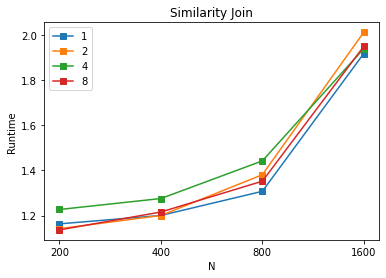

In [19]:
for i, runtime in enumerate(runtimes):
    plt.plot(runtime, marker="s", label=f"{NUM_BLOCKS[i]}")
    
plt.title("Similarity Join")
plt.ylabel("Runtime")
plt.xlabel("N")
plt.xticks(ticks=range(4), labels=[f"{n}" for n in Ns])
plt.legend()
plt.show()

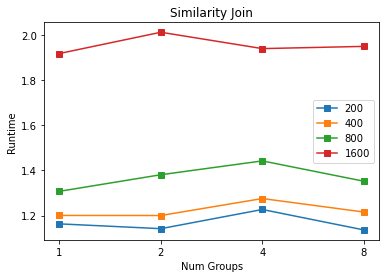

In [20]:
for i, runtime in enumerate(runtimes.T):
    plt.plot(runtime, marker="s", label=f"{Ns[i]}")
    
plt.title("Similarity Join")
plt.ylabel("Runtime")
plt.xlabel("Num Groups")
plt.xticks(ticks=range(4), labels=[f"{n}" for n in NUM_BLOCKS])
plt.legend()
plt.show()

# Quiz 2. Set Similarity Join

In [80]:
def create_inverted_list(line):
    set_id = line[0]
    elems = line[1]
    
    n = len(elems)
    
    for elem in elems:
        yield elem, set_id

In [4]:
def create_inverted_list_with_prefix(line, threshold):
    set_id = line[0]
    elems = line[1]
    
    n = len(elems)
    
    for i, elem in enumerate(elems):
        if i < n + int(math.ceil(n * threshold)) + 1:
            yield elem, set_id
        else:
            break

In [40]:
def create_candidates(elem_and_set_ids):
    set_ids = elem_and_set_ids[1]
    
    for comb in combinations(set_ids, 2):
        comb = tuple(sorted(comb))
        yield comb, 1

In [6]:
def compute_length(pair, N):
    setid = pair[0]
    elems = pair[1]
    
    for i in range(N):
        if i < setid:
            yield (i, setid), len(elems)
        elif i > setid:
            yield (setid, i), len(elems)

In [85]:
def set_similarity_join(N, threshold):
    dataset = create_setdata(N)
    dataset_rdd = sc.parallelize(dataset) \
                    .filter(lambda pair: len(pair[1]) >= 5).cache()
    
    threshold_rdd = dataset_rdd.flatMap(lambda pair: compute_length(pair, N)) \
                               .reduceByKey(lambda a, b: a + b) \
                               .mapValues(lambda v: (threshold / (1 + threshold)) * v)

    count = dataset_rdd.flatMap(create_inverted_list) \
                       .groupByKey() \
                       .flatMap(create_candidates) \
                       .reduceByKey(lambda a, b: a + b) \
                       .join(threshold_rdd) \
                       .filter(lambda v: v[1][0] >= v[1][1]) \
                       .count()
    
    return count

In [86]:
# def set_similarity_join2(N, threshold):
#     dataset = create_setdata(N)
#     dataset_rdd = sc.parallelize(dataset) \
#                     .filter(lambda pair: len(pair[1]) >= 5)

#     count = dataset_rdd.flatMap(partial(create_inverted_list_with_prefix, threshold=threshold)) \
#                        .groupByKey() \
#                        .flatMap(create_candidates) \
#                        .distinct() \
#                        .count()
    
#     return count

In [87]:
for threshold in JACCARD_THRESHOLD:
    
    for N in Ns:
        print(f"N: {N}, threshold: {threshold}")
        print(set_similarity_join(N, threshold))

N: 200, threshold: 0.6
0
N: 400, threshold: 0.6
1
N: 800, threshold: 0.6
9
N: 1600, threshold: 0.6
21
N: 200, threshold: 0.7
0
N: 400, threshold: 0.7
0
N: 800, threshold: 0.7
1
N: 1600, threshold: 0.7
1
N: 200, threshold: 0.8
0
N: 400, threshold: 0.8
0
N: 800, threshold: 0.8
1
N: 1600, threshold: 0.8
0
N: 200, threshold: 0.9
0
N: 400, threshold: 0.9
0
N: 800, threshold: 0.9
0
N: 1600, threshold: 0.9
0


In [88]:
runtimes_set = []

for threshold in JACCARD_THRESHOLD:
    runtime_set = []
    
    for N in Ns:
        print(f"N: {N}, threshold: {threshold}")
        start_time = time.time()
        set_similarity_join(N, threshold)
        runtime_set.append(time.time() - start_time)
        
    runtimes_set.append(runtime_set)
    
print(runtimes_set)

N: 200, threshold: 0.6
N: 400, threshold: 0.6
N: 800, threshold: 0.6
N: 1600, threshold: 0.6
N: 200, threshold: 0.7
N: 400, threshold: 0.7
N: 800, threshold: 0.7
N: 1600, threshold: 0.7
N: 200, threshold: 0.8
N: 400, threshold: 0.8
N: 800, threshold: 0.8
N: 1600, threshold: 0.8
N: 200, threshold: 0.9
N: 400, threshold: 0.9
N: 800, threshold: 0.9
N: 1600, threshold: 0.9
[[14.704907178878784, 15.176168203353882, 16.355415105819702, 19.786986112594604], [15.174668312072754, 15.691720724105835, 16.112298488616943, 21.236398220062256], [15.162031412124634, 14.812295198440552, 16.532480478286743, 20.134730577468872], [15.269489049911499, 15.010812044143677, 15.908846378326416, 20.299805879592896]]


In [89]:
runtimes_set = np.array(runtimes_set)
print(runtimes_set.shape)

(4, 4)


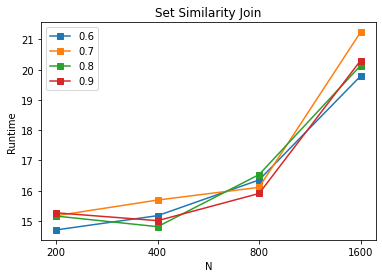

In [90]:
for i, runtime_set in enumerate(runtimes_set):
    plt.plot(runtime_set, marker="s", label=f"{JACCARD_THRESHOLD[i]}")
    
plt.title("Set Similarity Join")
plt.ylabel("Runtime")
plt.xlabel("N")
plt.xticks(ticks=range(4), labels=[f"{n}" for n in Ns])
plt.legend()
plt.show()

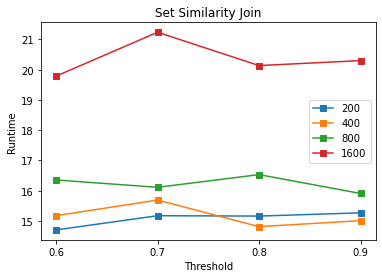

In [91]:
for i, runtime_set in enumerate(runtimes_set.T):
    plt.plot(runtime_set, marker="s", label=f"{Ns[i]}")
    
plt.title("Set Similarity Join")
plt.ylabel("Runtime")
plt.xlabel("Threshold")
plt.xticks(ticks=range(4), labels=[f"{t}" for t in JACCARD_THRESHOLD])
plt.legend()
plt.show()